<a href="https://colab.research.google.com/github/javinukem/CV-Project-Group-4/blob/main/GAN_Javier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from skimage.color import rgb2lab, lab2rgb
import numpy as np

In [3]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4, stride=2, padding=1),  # Increased filters from 64 to 96
            nn.ReLU(True),
            nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1),  # Increased filters from 128 to 192
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.Conv2d(192, 384, kernel_size=4, stride=2, padding=1),  # Increased filters from 256 to 384
            nn.BatchNorm2d(384),
            nn.ReLU(True),
            nn.Conv2d(384, 768, kernel_size=4, stride=2, padding=1),  # Increased filters from 512 to 768
            nn.BatchNorm2d(768),
            nn.ReLU(True),
            nn.ConvTranspose2d(768, 384, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(True),
            nn.ConvTranspose2d(384, 192, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 2, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [4]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)


In [5]:
# Initialize the models
netG = Generator()
netD = Discriminator()

In [6]:
# Loss function and optimizers
criterion = nn.BCELoss()

# Combined Loss Function
adversarial_loss = nn.BCELoss()  # Binary cross-entropy loss for GANs
pixelwise_loss = nn.L1Loss()  # L1 loss for pixel-wise accuracy

def compute_generator_loss(fake_output, real_ab, generated_ab):
    # Adversarial loss
    adversarial_loss_value = adversarial_loss(fake_output, torch.ones_like(fake_output))

    # Pixel-wise L1 loss
    pixelwise_loss_value = pixelwise_loss(generated_ab, real_ab)

    # Total loss (you can adjust the weights of these components as needed)
    total_loss = adversarial_loss_value + 100 * pixelwise_loss_value
    return total_loss


optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [7]:
# Helper functions for Lab color space conversion
def rgb_to_lab(img):
    lab_img = rgb2lab(img)
    l = lab_img[:, :, 0] / 100.0
    ab = lab_img[:, :, 1:] / 128.0
    return l, ab

def lab_to_rgb(l, ab):
    lab_img = np.zeros((l.shape[0], l.shape[1], 3))
    lab_img[:, :, 0] = l
    lab_img[:, :, 1:] = ab
    rgb_img = lab2rgb(lab_img)
    return rgb_img

# Dataset transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [8]:
# Load dataset (e.g., CIFAR-10)
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Reduce the size of the dataset by taking a subset
subset_size = 10000  # Choose the number of images you want to use
subset_indices = list(range(subset_size))
subset_dataset = Subset(full_dataset, subset_indices)

# Create a DataLoader for the subset
dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True, num_workers=2)



100%|██████████| 170498071/170498071 [00:02<00:00, 76779921.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Training loop (with modified generator updates)
num_epochs = 20

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Prepare real data
        real_images = data[0].numpy().transpose((0, 2, 3, 1))
        lab_images = np.array([rgb2lab(img) for img in real_images])

        l_channels = torch.tensor(lab_images[:, :, :, 0]).unsqueeze(1).float()
        ab_channels = torch.tensor(lab_images[:, :, :, 1:]).permute(0, 3, 1, 2).float()

        b_size = l_channels.size(0)
        real_lab = torch.cat((l_channels, ab_channels), dim=1)

        ############################
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # Train with real data
        label = torch.full((b_size,), 1., dtype=torch.float)
        output = netD(real_lab)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake data
        noise = torch.randn(b_size, 1, 64, 64)
        fake_ab = netG(noise)
        fake_lab = torch.cat((l_channels, fake_ab), 1)
        label.fill_(0.)

        output = netD(fake_lab.detach())  # Detach to avoid backprop through G
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update Generator: maximize log(D(G(z))) + L1 loss for color accuracy
        ###########################
        netG.zero_grad()
        label.fill_(1.)

        output = netD(fake_lab)  # Pass the fake data through D again
        adversarial_loss = criterion(output, label)

        # L1 loss for pixel-wise accuracy between the generated and real 'ab' channels
        l1_loss = nn.L1Loss()(fake_ab, ab_channels)

        # Combine the adversarial loss and L1 loss (you can scale L1 loss as needed)
        errG = adversarial_loss + 100 * l1_loss
        errG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {errD_real.item() + errD_fake.item()}, Loss_G: {errG.item()}")


In [ ]:
# Test and visualize results (this is just an example)
test_data = next(iter(dataloader))[0]
test_images = test_data.numpy().transpose((0, 2, 3, 1))
lab_images = np.array([rgb2lab(img) for img in test_images])
l_channels = torch.tensor(lab_images[:, :, :, 0]).unsqueeze(1).float()

with torch.no_grad():
    fake_ab = netG(l_channels)

# Convert back to RGB for visualization
generated_images = []
for i in range(fake_ab.size(0)):
    l = l_channels[i].squeeze(0).numpy()
    ab = fake_ab[i].permute(1, 2, 0).numpy()
    generated_image = lab_to_rgb(l, ab)
    generated_images.append(generated_image)

# Now `generated_images` contains the colorized images for visualization.


(64, 64, 64, 3)


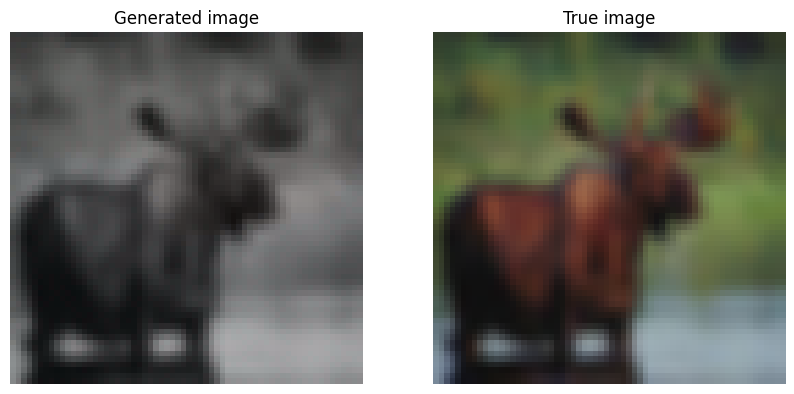

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(generated_images[0])
ax[0].set_title('Generated image')
ax[0].axis('off')
print(np.shape(generated_images))
ax[1].imshow(test_images[0])
ax[1].set_title('True image')
ax[1].axis('off')

plt.show()

